In [1]:
# rm(list=ls())
require(data.table)
require(MASS)
require(ggplot2)
require(foreach)
require(gridExtra)
require(doMC)
registerDoMC(cores=16)

## Resizing notebook plot space
options(repr.plot.width=16, repr.plot.height=9)

Loading required package: data.table
Loading required package: MASS
Loading required package: ggplot2
Loading required package: foreach
Loading required package: gridExtra
Loading required package: doMC
Loading required package: iterators
Loading required package: parallel


In [2]:
## POP DATA from UN
# pop <- data.table(fread("/home/j/Project/IRH/Forecasting/data/WPP_forecasted_population.csv"))
pop <- fread('/ihme/forecasting/data/pop/20150101_wpp/data.csv')

In [3]:
## Education forecasts
edu_orig<-data.table(fread(paste0("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/gpr_draws.csv"), header = T))
edu_orig <- edu_orig[, V1:=NULL]
# edu<-data.table(fread(paste0("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/intermediate/gpr_draws_wide_by_years.csv"), header = T))
# edu <- data.table(edu)

Read 496860 rows and 1005 (of 1005) columns from 6.600 GB file in 00:01:42


### Reshape long by draws, wide by year, use copula with spearman = 1, and reshape back AND collapse by country-year

In [4]:
# Make draws long first
system.time(edu_temp <- melt(edu_orig, id.vars = c("location_id", "age_group_id", "sex_id", "year_id"), value.name = "edu", varnames = "draw"))
head(edu_temp)

   user  system elapsed 
  4.113   1.200   5.310 

location_id,age_group_id,sex_id,year_id,variable,edu
6,8,1,1950,draw0,2.193899
6,8,1,1951,draw0,2.329269
6,8,1,1952,draw0,2.472498
6,8,1,1953,draw0,2.623456
6,8,1,1954,draw0,2.781863
6,8,1,1955,draw0,2.947277


In [6]:
## Tests
# test_pre_cop <- edu_temp[location_id==6 & age_group_id==8 & sex_id==2,]
# ggplot(data.frame(test_pre_cop)) + geom_line(aes(x = year_id, y = edu, group = variable, color=variable)) +
# theme(legend.position = "none")

In [5]:
# Wide by year
system.time(edu <- dcast(edu_temp , 
                         formula = location_id + age_group_id + sex_id + variable ~ year_id, 
                         value.var = "edu"))
head(edu)

   user  system elapsed 
121.820   7.281 128.660 

location_id,age_group_id,sex_id,variable,1950,1951,1952,1953,1954,1955,⋯,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
6,8,1,draw0,2.193899,2.329269,2.472498,2.623456,2.781863,2.947277,⋯,10.61860,10.75390,10.90354,11.06686,11.24293,11.43053,11.62815,11.83401,12.04621,12.26270
6,8,1,draw1,3.696831,3.838159,3.986922,4.143215,4.307003,4.478090,⋯,14.16637,14.27173,14.37247,14.46881,14.56084,14.64857,14.73192,14.81077,14.88496,14.95434
6,8,1,draw2,3.899294,4.045678,4.199735,4.361473,4.530767,4.707342,⋯,13.18282,13.32350,13.46327,13.60189,13.73900,13.87424,14.00721,14.13758,14.26503,14.38927
6,8,1,draw3,5.886914,6.013686,6.134196,6.248749,6.357675,6.461299,⋯,11.96426,12.07390,12.18610,12.30015,12.41525,12.53049,12.64490,12.75743,12.86707,12.97276
6,8,1,draw4,3.221693,3.346715,3.484166,3.634715,3.798821,3.976678,⋯,13.36790,13.49448,13.61534,13.73089,13.84166,13.94830,14.05160,14.15239,14.25154,14.34994
6,8,1,draw5,3.998282,4.065710,4.133698,4.203069,4.274492,4.348449,⋯,10.97587,11.08692,11.19426,11.29749,11.39635,11.49061,11.58017,11.66496,11.74503,11.82050


### Neal's Copula Function (rho = 1)

In [7]:
rank_time_series <- function(X, corr, ts=F, print=FALSE){
  draws <- nrow(X)
  years <- ncol(X)
  # X <- matrix(runif(draws*years), nrow=years, ncol=draws)
  
  if(print){
    print(sapply(2:years, function(x) cor(X[x,], X[x-1,])))
  }
  
  if(ts == F) {
    corr_mat <- matrix(data=corr, nrow= years, ncol= years )
    diag(corr_mat) <- 1
  }
  
  if(ts == T) {
    corr_mat <- corr**abs(outer(0:(years-1), 0:(years-1), "-"))
  }
  
  
#   print(corr_mat)
  mvdat <- mvrnorm(n= draws, mu=0 * 1:ncol(X), Sigma=corr_mat, empirical=T)
  ranks <- apply(mvdat, 2, rank, ties.method="first")
  sorted_X <- apply(X, 2, sort)
  sapply(1:ncol(X), function(x) sorted_X[,x][ranks[,x]])
}



### Let's differentiate each chunks of unique loc_id, age, sex

In [8]:
# locs <- unique(edu[,location_id])
# ages <- unique(edu[,age_group_id])
# sexs <- unique(edu[,sex_id])
# edu <- data.table(edu)
edu <- edu[, id := .GRP, by = .(location_id, age_group_id, sex_id)]
edu <- setcolorder(edu, c("id", colnames(edu)[1:dim(edu)[2]-1]))

## Unique ID var
unique<- unique(edu[,id])
head(edu)

id,location_id,age_group_id,sex_id,variable,1950,1951,1952,1953,1954,⋯,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
1,6,8,1,draw0,2.193899,2.329269,2.472498,2.623456,2.781863,⋯,10.61860,10.75390,10.90354,11.06686,11.24293,11.43053,11.62815,11.83401,12.04621,12.26270
1,6,8,1,draw1,3.696831,3.838159,3.986922,4.143215,4.307003,⋯,14.16637,14.27173,14.37247,14.46881,14.56084,14.64857,14.73192,14.81077,14.88496,14.95434
1,6,8,1,draw2,3.899294,4.045678,4.199735,4.361473,4.530767,⋯,13.18282,13.32350,13.46327,13.60189,13.73900,13.87424,14.00721,14.13758,14.26503,14.38927
1,6,8,1,draw3,5.886914,6.013686,6.134196,6.248749,6.357675,⋯,11.96426,12.07390,12.18610,12.30015,12.41525,12.53049,12.64490,12.75743,12.86707,12.97276
1,6,8,1,draw4,3.221693,3.346715,3.484166,3.634715,3.798821,⋯,13.36790,13.49448,13.61534,13.73089,13.84166,13.94830,14.05160,14.15239,14.25154,14.34994
1,6,8,1,draw5,3.998282,4.065710,4.133698,4.203069,4.274492,⋯,10.97587,11.08692,11.19426,11.29749,11.39635,11.49061,11.58017,11.66496,11.74503,11.82050


In [10]:
# ## Test for one case
# tesssst_1 <- rank_time_series(edu[location_id==102 & age_group_id==8 & sex_id==2,  6:96], corr = 1, ts = F,print=F)
# colnames(tesssst_1) <- paste0(c(1950:2040))
# tesssst_1 <- cbind(edu[location_id==6 & age_group_id==8 & sex_id==2,  1:5], tesssst_1)
# tesssst_2 <- data.table(melt(tesssst_1[, id :=NULL], id.vars=c("location_id", "age_group_id", "sex_id","variable"), value.name = "edu", variable.name = "year_id"))
# head(tesssst_1)

# ggplot(data.frame(tesssst_2)) + geom_line(aes(x=year_id, y = edu, group = variable, color=variable)) +
# theme(legend.position = "none")

### Use copula on all the data with Spearman = 1

In [11]:
Start<- Sys.time()

alist<-list()
alist<- foreach(i = unique(edu[,id])) %dopar% {
    tempx <-  rank_time_series(edu[id==i, 6:96], corr = 1, ts = F,print=F)
    tempx <- cbind(edu[id==i, 1:5], tempx)
}


### Equivalent to the follow mclapply set up:

# test_func <- function(id_subset) {
#     results <- rank_time_series(edu[id==id_subset, 6:96], corr=1, ts=F, print=F)
#     results <- cbind(edu[id == id_subset, 1:5], results)
#     return(results)
# }

# test <- rbindlist(mclapply(unique(edu[,id]), test_func, mc.cores=32))

print(Sys.time()-Start)

edu_fill_cyas <- do.call(rbind, alist)
colnames(edu_fill_cyas) <- c("id", "location_id", "age_group_id", "sex_id", "variable", c(1950:2040))

Time difference of 1.834441 mins


In [11]:
## Test plotss
# test_post_1 <- edu_fill_cyas[id == 2,]
# test_post_1 <- melt(test_post_1, id.vars = c("id", "location_id", "age_group_id", "sex_id", "variable"), value.name = "edu", variable.name = "year_id")
# head(test_post_1)

# ggplot(data.frame(test_post_1)) + geom_line(aes(x=year_id, y = edu, group = variable, color=variable)) +
# theme(legend.position = "none")

In [12]:
# fwrite(edu_fill_cyas, "/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/intermediate/gpr_draws_wide_by_years_sorted.csv")

### Reshape to normal shape, and collapse to C-Y

In [12]:
edu_fill_cyas <- edu_fill_cyas[, id:=NULL]
blank2_melt <- data.table(melt(edu_fill_cyas, id.vars = c("location_id", "age_group_id", "sex_id", "variable"), variable.name = "year_id", value.name = "data"))

In [13]:
system.time(blank2_cast <- dcast(blank2_melt, location_id + age_group_id + sex_id + year_id ~ variable ))
head(blank2_cast)

Using 'data' as value column. Use 'value.var' to override


   user  system elapsed 
108.865  11.319 120.066 

location_id,age_group_id,sex_id,year_id,draw0,draw1,draw2,draw3,draw4,draw5,⋯,draw990,draw991,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999
6,8,1,1950,3.307142,2.827592,2.757948,4.249206,5.071394,2.934557,⋯,4.356751,2.322269,4.180469,2.513109,5.162916,3.092854,4.724487,3.388213,5.577312,4.587908
6,8,1,1951,3.432201,2.930555,2.842276,4.378471,5.228244,3.035745,⋯,4.487801,2.428924,4.295475,2.647629,5.314488,3.221662,4.805875,3.511333,5.732302,4.730828
6,8,1,1952,3.548912,3.049224,2.949065,4.514694,5.370476,3.165093,⋯,4.640748,2.536450,4.405833,2.749598,5.427717,3.351692,4.929192,3.667129,5.864775,4.859758
6,8,1,1953,3.684932,3.173875,3.082214,4.652346,5.492283,3.293656,⋯,4.758147,2.632981,4.541372,2.860612,5.565173,3.465849,5.080461,3.783408,5.984173,4.995233
6,8,1,1954,3.834647,3.344003,3.211056,4.776449,5.632452,3.425592,⋯,4.881382,2.749436,4.668414,2.973653,5.732036,3.609709,5.233688,3.927052,6.112901,5.120862
6,8,1,1955,3.973987,3.494659,3.342684,4.882421,5.780095,3.553808,⋯,5.012857,2.873348,4.807740,3.080803,5.843649,3.743763,5.368539,4.070804,6.262446,5.249734


In [24]:
blank2_cast <- data.table(blank2_cast)

location_id,age_group_id,sex_id,year_id,draw0,draw1,draw2,draw3,draw4,draw5,⋯,draw990,draw991,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999
6,8,1,1950,3.307142,2.827592,2.757948,4.249206,5.071394,2.934557,⋯,4.356751,2.322269,4.180469,2.513109,5.162916,3.092854,4.724487,3.388213,5.577312,4.587908
6,8,1,1951,3.432201,2.930555,2.842276,4.378471,5.228244,3.035745,⋯,4.487801,2.428924,4.295475,2.647629,5.314488,3.221662,4.805875,3.511333,5.732302,4.730828
6,8,1,1952,3.548912,3.049224,2.949065,4.514694,5.370476,3.165093,⋯,4.640748,2.536450,4.405833,2.749598,5.427717,3.351692,4.929192,3.667129,5.864775,4.859758
6,8,1,1953,3.684932,3.173875,3.082214,4.652346,5.492283,3.293656,⋯,4.758147,2.632981,4.541372,2.860612,5.565173,3.465849,5.080461,3.783408,5.984173,4.995233
6,8,1,1954,3.834647,3.344003,3.211056,4.776449,5.632452,3.425592,⋯,4.881382,2.749436,4.668414,2.973653,5.732036,3.609709,5.233688,3.927052,6.112901,5.120862
6,8,1,1955,3.973987,3.494659,3.342684,4.882421,5.780095,3.553808,⋯,5.012857,2.873348,4.807740,3.080803,5.843649,3.743763,5.368539,4.070804,6.262446,5.249734


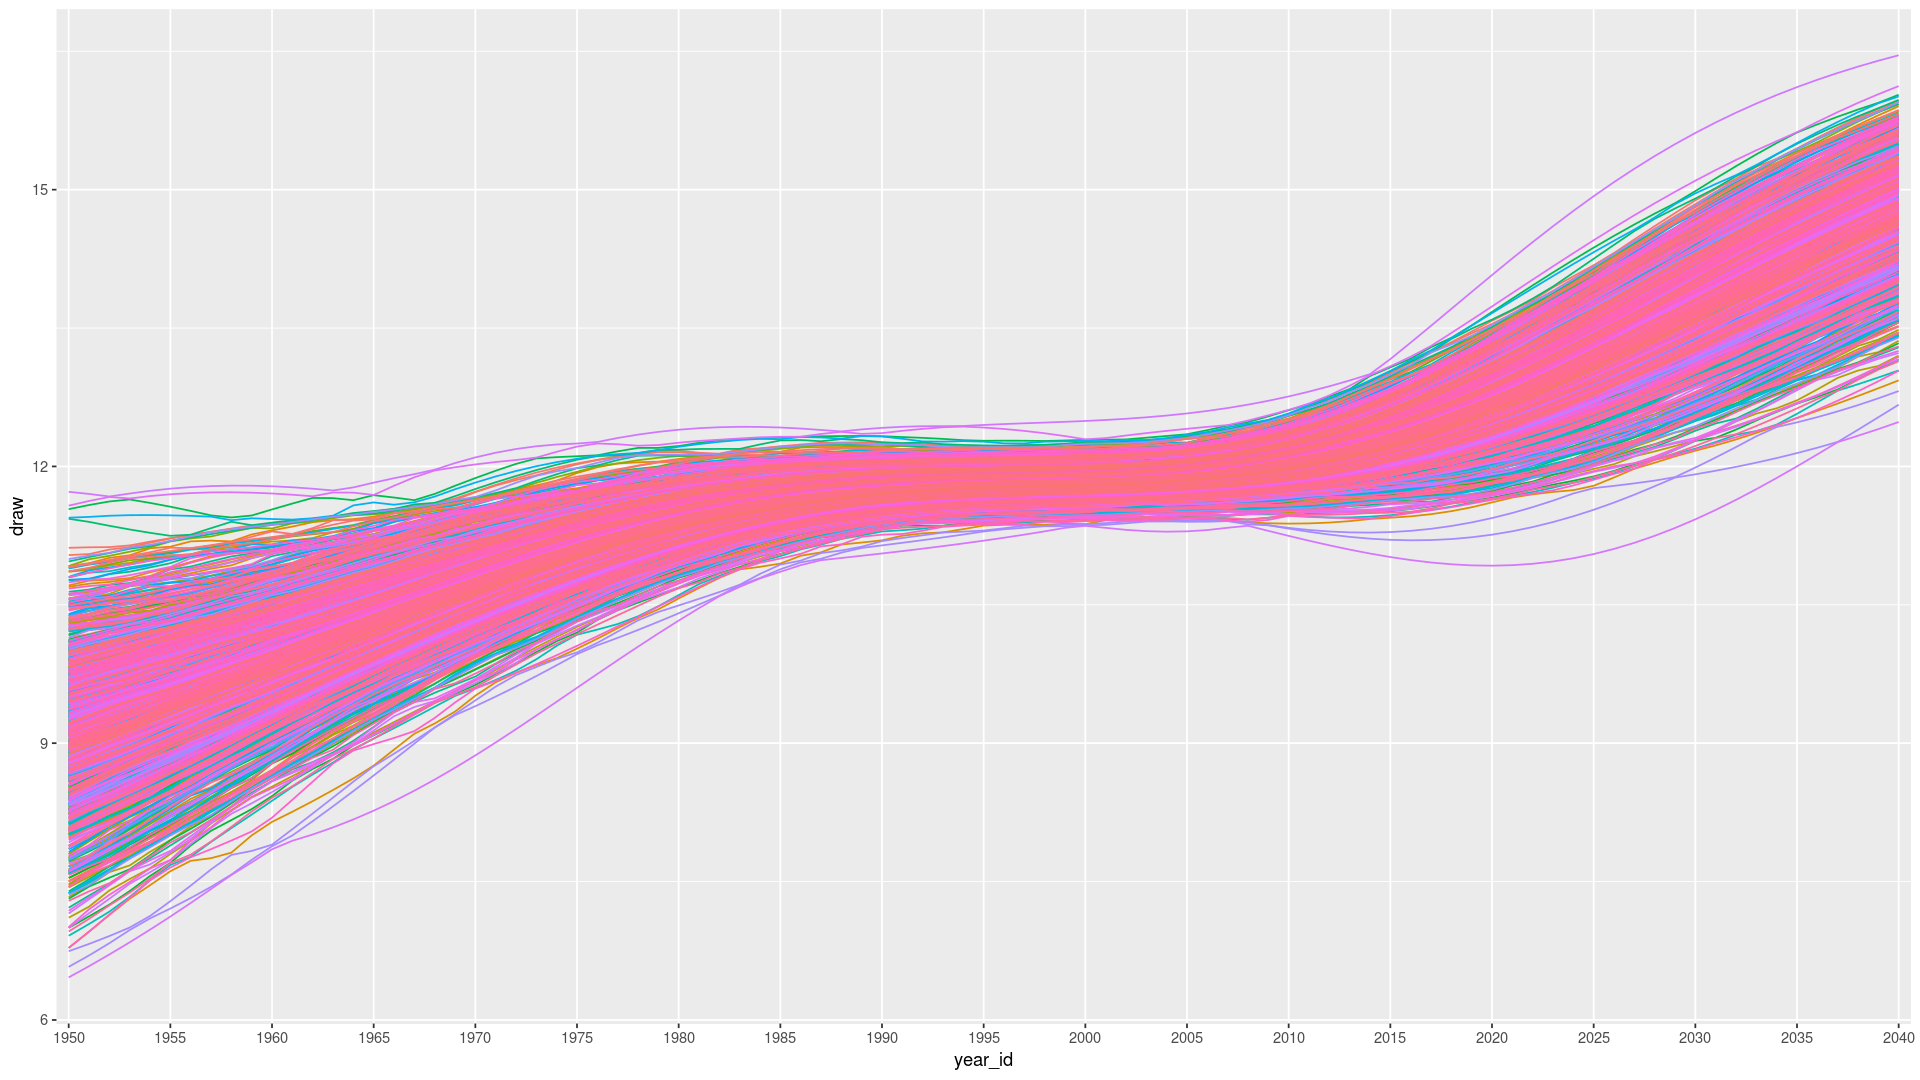

In [32]:
head(blank2_cast)
plot_country_year_AS <- function(loc_id, age = 8, sex= 2) {
    return(ggplot(melt(blank2_cast[location_id==loc_id & age_group_id == age & sex_id == sex, ], 
                       id.vars = c("location_id", "age_group_id", "sex_id", "year_id"), 
                       value.name = "draw") ) + 
    geom_line(aes(x=year_id, y=draw, group=variable, color=variable)) + 
    scale_x_discrete(breaks = seq(1950,2040,by=5)) +
    theme(legend.position = "none"))    +
    ggtitle("Country-Year-Age-Sex Sorted")
    }

i <- 102
plot_country_year_AS(i)

In [30]:
key(blank2_cast)

[1] "location_id"  "age_group_id" "sex_id"       "year_id"

In [31]:
system.time(fwrite(data.table(blank2_cast), "/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/gpr_draws_country_year_age_sex_post_copula.csv"))

   user  system elapsed 
719.318   4.216  26.177 

In [33]:
## Testing written CSV
# blank2_cast_test<- fread("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/gpr_draws_country_year_age_sex_post_copula.csv", header=T)

Read 496860 rows and 1004 (of 1004) columns from 6.596 GB file in 00:01:47


In [56]:
# head(blank2_cast_test)
# plot_country_year_AS_test <- function(loc_id, age = 8, sex= 1) {
#     return(ggplot(melt(blank2_cast_test[location_id==loc_id & age_group_id == age & sex_id == sex, ], 
#                        id.vars = c("location_id", "age_group_id", "sex_id", "year_id"), 
#                        value.name = "draw") ) + 
#     geom_line(aes(x=year_id, y=draw, group=variable, color=variable)) + 
#     scale_x_discrete(breaks = seq(1950,2040,by=5)) +
#     theme(legend.position = "none"))    +
#     ggtitle("Country-Year-Age-Sex Sorted")
#     }

# i <- 201
# plot_country_year_AS_test(i)

### Collapse to year and country only

In [40]:
# blank2_cast <- fread("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/gpr_draws_country_year_age_sex_post_copula.csv")
edu2 <- data.table(merge.data.frame(blank2_cast, pop, by = c("location_id", "year_id", "age_group_id", "sex_id")))
setkeyv(edu2, c("location_id", "year_id", "age_group_id", "sex_id"))

ERROR: Error in setkeyv(x, cols, verbose = verbose, physical = physical): some columns are not in the data.table: c("location_id", "year_id", "age_group_id", "sex_id")


In [50]:
edu4<- edu2[, lapply(.SD, function(x) sum(x*pop)/sum(pop)), 
    by=c("location_id", "year_id"), .SDcols=cbind(paste0("draw",c(0:999))) ] 

unique2 <- unique(edu4[, location_id])    
head(edu4)

location_id,year_id,draw0,draw1,draw2,draw3,draw4,draw5,draw6,draw7,⋯,draw990,draw991,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999
6,1950,2.645154,2.338911,2.215635,2.356409,2.311006,2.637207,2.598514,2.703716,⋯,2.623432,2.567646,2.953635,2.538061,2.742645,2.654224,2.925377,2.380497,2.988505,2.445686
6,1951,2.733160,2.418230,2.289790,2.430288,2.391773,2.711155,2.679904,2.796497,⋯,2.709355,2.647406,3.030729,2.621269,2.829784,2.740444,3.007706,2.463147,3.073169,2.527796
6,1952,2.821512,2.503471,2.372092,2.510112,2.474177,2.791896,2.767157,2.889029,⋯,2.800404,2.733829,3.107230,2.703144,2.907102,2.829295,3.092795,2.550813,3.155087,2.605103
6,1953,2.916135,2.589439,2.457069,2.588784,2.557861,2.875765,2.853647,2.978906,⋯,2.891438,2.818666,3.198463,2.786409,2.995532,2.918566,3.183755,2.637424,3.236606,2.689630
6,1954,3.009385,2.681167,2.549024,2.675051,2.645965,2.961578,2.942888,3.085022,⋯,2.975036,2.905795,3.285786,2.874933,3.088882,3.014471,3.273646,2.728941,3.329860,2.776312
6,1955,3.099141,2.774245,2.640853,2.757904,2.736391,3.046350,3.030887,3.181736,⋯,3.071211,2.999301,3.383200,2.966008,3.177256,3.107616,3.356422,2.821734,3.422766,2.866393


In [ ]:
### PROBLEM: No population data for MHL (loc == 26) apparently (fix it)

### Copula this one? (uncomment if that's the intention)

In [ ]:
# edu4_1 <- melt(edu4[year_id >=1980,], id.vars = c("location_id", "year_id"), value.name = "edu", variable.name = "draw_num")
# edu4_2 <- data.table(dcast(edu4_1, location_id + draw_num ~ year_id, value.var = "edu"))
# head(edu4_2)

In [ ]:
# Start<- Sys.time()
# edu5 <- data.table()
# for(i in unique(edu4_2[,location_id])) {
#     temploc <- edu4_2[location_id==i, 1:2]
#     tempx <-  rank_time_series(edu4_2[location_id==i, 3:63], corr = 1, ts = F,print=F)
#     tempx <- cbind(temploc, tempx)
#     edu5 <- rbind(edu5, tempx)
# }

# colnames(edu5) <- c("location_id", "draw_", paste0(c(1980:2040)))
# # head(tempx)
                
# print(Sys.time()-Start)
# tail(edu5)

In [ ]:
# edu5_1 <- melt(edu5, id.vars = c("location_id", "draw_"), value.name = "edu", variable.name = "year_id")
# edu5_2 <- dcast(edu5_1, location_id + year_id ~ draw_, value.var = "edu")

In [38]:
head(edu4)

location_id,year_id,draw0,draw1,draw2,draw3,draw4,draw5,draw6,draw7,⋯,draw990,draw991,draw992,draw993,draw994,draw995,draw996,draw997,draw998,draw999
10,1950,2.088936,1.493765,1.489711,1.512752,1.431389,1.550843,1.374986,1.524658,⋯,1.875978,1.701115,1.518891,1.421298,1.595221,1.496749,1.903737,1.435987,1.447294,1.678715
10,1951,2.126263,1.522114,1.514772,1.543337,1.459777,1.582070,1.401953,1.551390,⋯,1.905916,1.729579,1.551486,1.446365,1.623611,1.522569,1.934133,1.460551,1.475083,1.708334
10,1952,2.166734,1.554504,1.540507,1.573380,1.484798,1.611417,1.433847,1.583383,⋯,1.931434,1.760964,1.583524,1.469362,1.658791,1.545651,1.971397,1.488679,1.504937,1.741991
10,1953,2.202534,1.586625,1.564977,1.603010,1.516019,1.640790,1.466314,1.615613,⋯,1.963923,1.790950,1.613981,1.499188,1.696289,1.575663,2.001971,1.517004,1.535792,1.775891
10,1954,2.234942,1.615337,1.593482,1.635896,1.549018,1.677008,1.498811,1.650878,⋯,2.000078,1.829416,1.642391,1.529084,1.732180,1.602002,2.033585,1.548470,1.568389,1.804807
10,1955,2.271725,1.648526,1.623685,1.668335,1.583290,1.708766,1.532959,1.683452,⋯,2.028535,1.858978,1.678617,1.561333,1.764299,1.632762,2.064248,1.581399,1.605548,1.835417


In [55]:
system.time(fwrite(edu4, "/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/gpr_draws_country_year_collapsed_after_sort.csv"))
# fwrite(edu5_2, "/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/gpr_draws_country_year_collapsed_after_sort.csv")

   user  system elapsed 
 22.442   0.231   0.903 

In [52]:
# Test test test

plot_country_year <- function(loc_id) {
    return(ggplot(melt(data.table(edu4)[location_id==loc_id  , ], id.vars = c("location_id", "year_id"), value.name = "draw") ) + 
    geom_line(aes(x=year_id, y=draw, group=variable, color=variable)) + 
    scale_x_discrete(breaks = seq(1950,2040,by=5)) +
    theme(legend.position = "none"))+
    ggtitle("Country-Year Collapsed")
    }



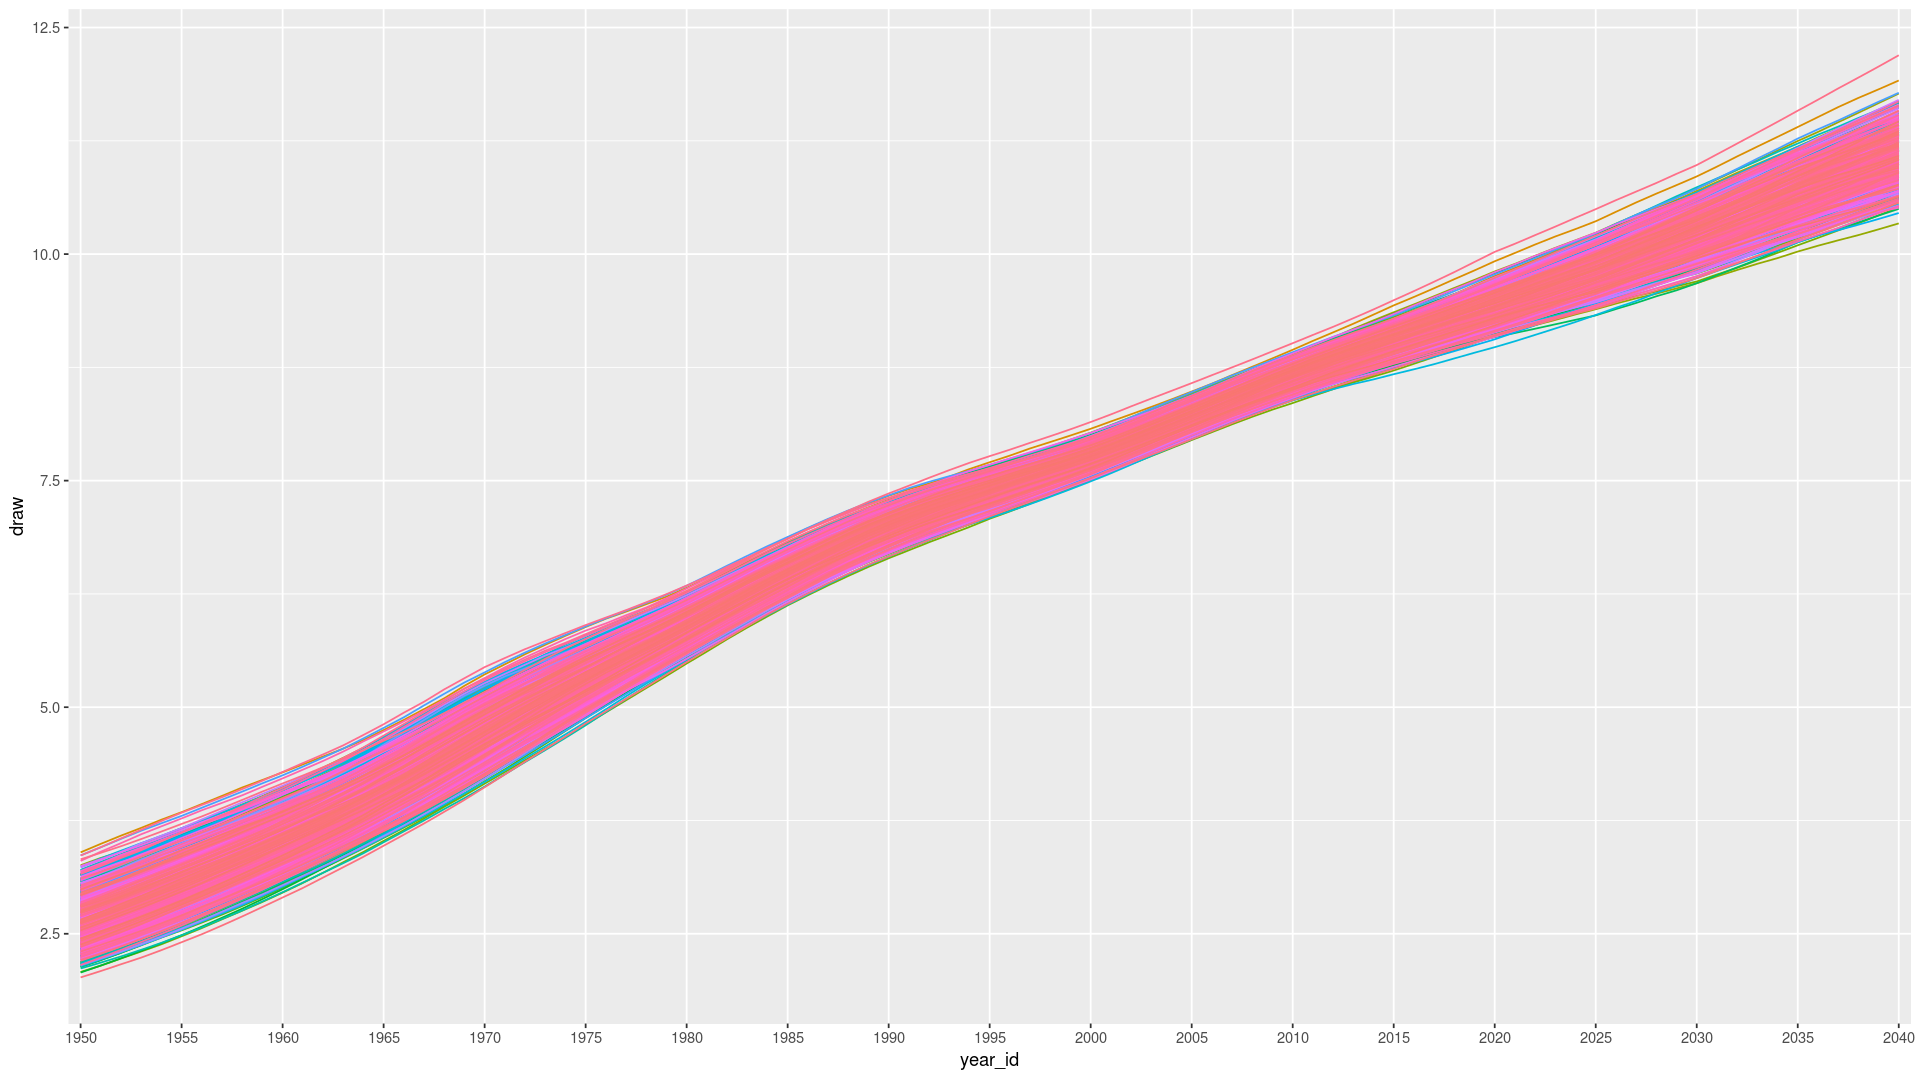

In [54]:
plot_country_year(6)